In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.special import factorial
from scipy.optimize import fsolve

# Activity - 1

In [47]:
n, p_true, N = 1, .5, 100 # number of trials, probability of each trial (one binomial trial is N bernoulli trials)
data = np.random.binomial(n, p_true, N) #(N = 100)

In [48]:
print(data)

[1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0]


### Likelihood function is a binomial distribution with N = 100 bernoulli trials. 
### Probability of getting $x$ from a bernoulli distribution is, $P(X=x) = p^x (1-p)^{(1-x)}$ 
### Likelihood, $L(p) = \prod_{n_i=1}^{N} p^{n_i} (1-p)^{(1-n_i)}$ \\
### $\log {L(p)} = \sum_{n_i=1}^{N} (n_i \log{p} + (1-n_i) \log{(1-p)})$\\ 
### suppose, $k =$ number of heads, $L(k, p) = {N \choose k} p^k(1-p)^{(N-k)}$ \\
### So, $\log{L(k, p)} = \log {\frac{N!}{k! (N - k)!} + k\log{p} + (N-k)\log{(1-p)}$ \\
### maximization of $L(p)$ interms of $p$ will give us, \\
### $\frac{\partial \log{L(p)}}{\partial p} = \sum_{n_i=1}^{N} (\frac{n_i}{p} - \frac{1-n}{1-p}) = 0$ \\
### so, the maximum likelihood estimator of p, $\hat{p} = \frac{\sum_{n_i = 1}^{N} n_i}{N}$

In [49]:
p_true = np.random.uniform(0,1,100)
while np.any(p_true == 0) or np.any(p_true == 1):
    p_true = np.random.uniform(0, 1, 100)
n = 1
N = 100
#p_fit = np.array([])
#k = np.array([])
def data(n, p, N):
    p_fit = np.array([])
    k = np.array([])
    for i, element in enumerate(p_true):
        result = np.random.binomial(n, element, N)
        heads = np.sum(result == 1) ## number of heads
        p_MLE = np.sum(result)/len(result)
        p_fit = np.append(p_fit, p_MLE)
        k = np.append(k, heads)
        #print(p_MLE)
    return result, k, p_fit

In [50]:
points, k, p_fit = data(n, p_true, N)

In [77]:
def log_likelihood(k, p):
    return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p) 

def func(k, p, p_fit):
    return log_likelihood(k, p) - log_likelihood(k, p_fit) + 1/2
    

def pfit_unsertainty(k, p_fit):
    roots = np.array([])
    for k_i, p_i in zip(k, p_fit):  # Iterate over k and p_fit together
        root = fsolve(lambda p: func(k_i, p, p_i), p_i)[0]  # Solve for p
        roots = np.append(roots, root)
    return np.array(roots)

/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)


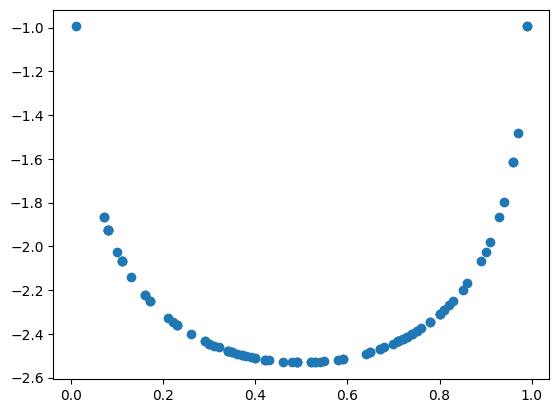

In [78]:
plt.scatter(p_fit, log_likelihood(k, p_fit))
plt.show()

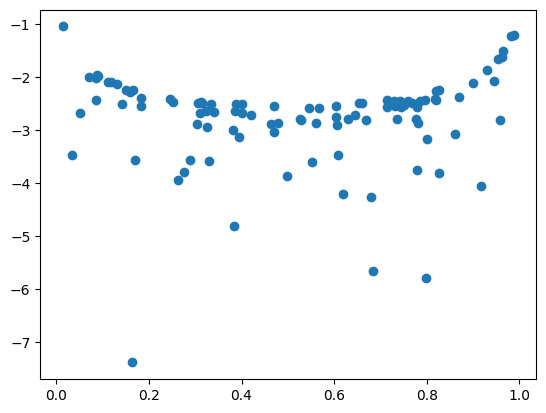

In [79]:
plt.scatter(p_true, log_likelihood(k, p_true))
plt.show()

In [80]:
## fit is just for the weights in activity 3

/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)


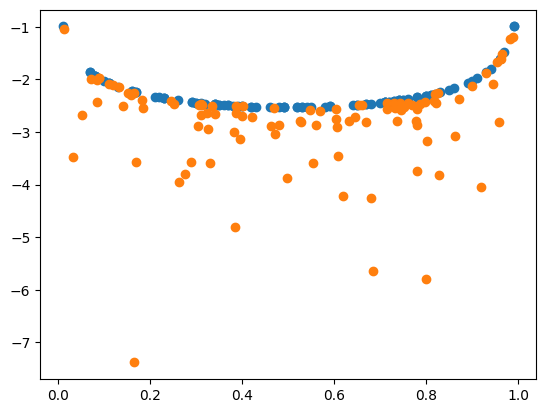

In [81]:
plt.scatter(p_fit, log_likelihood(k, p_fit))
plt.scatter(p_true, log_likelihood(k, p_true))
plt.show()

/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: invalid value encountered in scalar multiply
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(factorial(N)/(factorial(k)*factorial(N - k))) + k*np.log(p) + (N-k)*np.log(1-p)
/var/folders/wf/g8gqpsyj7450s95dwb4bbg7c0000gn/T/ipykernel_2899/2279306194.py:

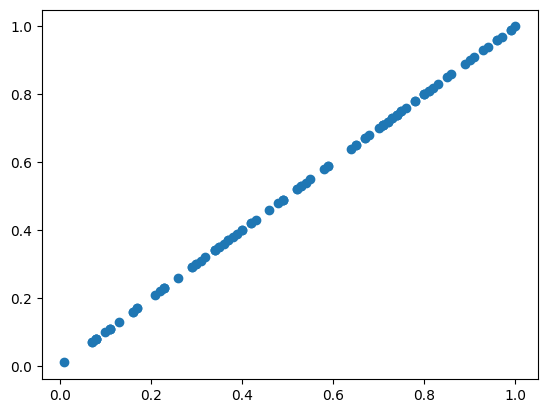

In [83]:
p_uncertainty = pfit_unsertainty(k, p_fit) 
plt.scatter(p_fit, p_uncertainty)
plt.show()